# Credit Scoring Model Development at Bati Bank
### This project focuses on developing a machine learning model to classify credit scores based on a person's credit-related information.
### Objectives of the Project
#### •	Develop a proxy variable to categorize users as high or low risk.
#### •	Select features with high correlation to the default variable.
#### •	Build a model that estimates risk probability for new customers.
#### •	Create a credit scoring system using risk probability estimates.
#### •	Optimize loan amount and duration using model predictions.

In [2]:
!pip install skimpy

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 25.3 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
  Attempting uninstall: polars
    Found existing installation: polars 1.7.1
    Uninstalling polars-1.7.1:
      Successfully uninstalled polars-1.7.1
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipyker

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimpy import clean_columns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)


Read Data Set

In [4]:
df = pd.read_csv("/content/data.csv")

In [5]:
df.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.000,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.000,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.000,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.000,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.000,644,2018-11-15T03:34:21Z,2,0


In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TransactionId         95662 non-null  object 
 1   BatchId               95662 non-null  object 
 2   AccountId             95662 non-null  object 
 3   SubscriptionId        95662 non-null  object 
 4   CustomerId            95662 non-null  object 
 5   CurrencyCode          95662 non-null  object 
 6   CountryCode           95662 non-null  int64  
 7   ProviderId            95662 non-null  object 
 8   ProductId             95662 non-null  object 
 9   ProductCategory       95662 non-null  object 
 10  ChannelId             95662 non-null  object 
 11  Amount                95662 non-null  float64
 12  Value                 95662 non-null  int64  
 13  TransactionStartTime  95662 non-null  object 
 14  PricingStrategy       95662 non-null  int64  
 15  FraudResult        

## This dataset provides information about various transactions:
   ### Column Breakdown:
             TransactionId: Unique identifier for each transaction.
             BatchId: Identifier for batches of transactions.
             AccountId: The account associated with the transaction.
             SubscriptionId: Identifier for subscription services linked to the transaction.
             CustomerId: Unique identifier for the customer.
             CurrencyCode: Currency used in the transaction (e.g., UGX for Ugandan Shilling).
             CountryCode: Numeric country code (e.g., 256).
             ProviderId: Identifier for the service provider (e.g., telecom, utility companies).
             ProductId: Identifier for the product sold (e.g., airtime, utility bill, financial services).
             ProductCategory: The category the product belongs to (e.g., airtime, financial_services, utility_bill).
             ChannelId: Identifier for the transaction channel (e.g., mobile, online).
             Amount: The amount transacted, usually in float format.
             Value: Corresponding value of the transaction (could be the total cost, including fees).
             TransactionStartTime: Timestamp of when the transaction started.
             PricingStrategy: Identifier for different pricing strategies applied to the transaction.
             FraudResult: Indicator for whether the transaction was flagged as fraudulent (0 for non-fraud, 1 for fraud).
   #### Considerations:
##### The Amount column includes positive and negative values (e.g., -20.000), which likely represent refunds, charges, or reversals.
#####  convert the TransactionStartTime to a proper datetime format for time-based analysis.
##### The FraudResult can be used for classification tasks, making this a supervised learning dataset if you aim to predict fraudulent transactions.
#### Next Steps:
   #####  Data Cleaning
   #####  Feature Engineering: Create new features, such as time-based features (hour, day, month) or aggregating transaction amounts by CustomerId.
   ##### Fraud Detection: we can build a model to classify fraudulent transactions using the FraudResult as the target.

**Data Cleaning**

In [7]:
df.shape

(95662, 16)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CountryCode,95662.000,256.000,0.000,256.000,256.000,256.000,256.000,256.000
Amount,95662.000,6717.846,123306.797,-1000000.000,-50.000,1000.000,2800.000,9880000.000
Value,95662.000,9900.584,123122.088,2.000,275.000,1000.000,5000.000,9880000.000
PricingStrategy,95662.000,2.256,0.733,0.000,2.000,2.000,2.000,4.000
FraudResult,95662.000,0.002,0.045,0.000,0.000,0.000,0.000,1.000


In [9]:
df.describe(include = "object").T

,count,unique,top,freq
TransactionId,95662,95662,TransactionId_35670,1
BatchId,95662,94809,BatchId_67019,28
AccountId,95662,3633,AccountId_4841,30893
SubscriptionId,95662,3627,SubscriptionId_3829,32630
CustomerId,95662,3742,CustomerId_7343,4091
CurrencyCode,95662,1,UGX,95662
ProviderId,95662,6,ProviderId_4,38189
ProductId,95662,23,ProductId_6,32635
ProductCategory,95662,9,financial_services,45405
ChannelId,95662,4,ChannelId_3,56935


#### Summary Statistics:
CountryCode:

        Count: 95,662 entries.
        Mean: 256.
        Standard Deviation (std): 0.
        Min, 25%, 50%, 75%, Max: All values are 256.
        This suggests that all transactions are from the same country (likely Uganda, based on the country code 256).
Amount:

        Mean: 6,717.85.
        Std: 123,306.80, indicating high variability in transaction amounts.
        Min: -1,000,000, showing possible large refunds or reversals.
        25th percentile: -50, implying some transactions were negative.
        Median (50%): 1,000.
        75th percentile: 2,800.
        Max: 9,880,000, a very high transaction, which may indicate outliers.
Value:

        Mean: 9,900.58.
        Std: 123,122.09, again showing high variability.
        Min: 2.
        25th percentile: 275.
        Median: 1,000.
        75th percentile: 5,000.
        Max: 9,880,000, similar to the Amount column, indicating they are related or correlated.
PricingStrategy:

        Mean: 2.26, with a Std of 0.733.
        The values range from 0 to 4, indicating different pricing strategies applied to the transactions. The majority fall around 2.
FraudResult:

        Mean: 0.002, indicating a very low incidence of fraud.
        Std: 0.045.
        The min and 25th to 75th percentiles are all 0, with the max at 1.
        This suggests that fraud is rare, with only a small fraction of transactions marked as fraudulent (fraud rate is ~0.2%).
Observations:

        The dataset is dominated by non-fraudulent transactions, as seen in the FraudResult column.
        The Amount and Value columns have a high standard deviation and extreme values, which may indicate the presence of outliers or highly varied transaction sizes.
        CountryCode shows no variation, so it likely doesn't need further analysis unless multi-country data is expected.
        There are negative amounts, which should be investigated to understand if they represent refunds, reversals, or errors.
Next Steps:
    
    Outlier Detection: Since Amount and Value have extreme values, investigate outliers further, perhaps using a boxplot or z-scores.
    Fraud Analysis: Given the low fraud rate, you could try techniques like SMOTE for class imbalance before building fraud detection models.
Correlation:
        
        Check for correlations between Amount, Value, and FraudResult to see if higher amounts are associated with fraud.  

**Missing Values**

In [11]:
# Checking for missing values
missing_values = df.isnull().sum()
print(missing_values)

TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64


**Handling Negative Values in Amount**

In [12]:
# Check for negative values in 'Amount'
negative_amounts = df[df['Amount'] < 0]
print(f"Number of negative amounts: {len(negative_amounts)}")

# Display some examples of negative amounts
negative_amounts.head()


Number of negative amounts: 38189


,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.000,20,2018-11-15T02:19:08Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.000,644,2018-11-15T03:34:21Z,2,0
7,TransactionId_100640,BatchId_38561,AccountId_4841,SubscriptionId_3829,CustomerId_2858,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-500.000,500,2018-11-15T03:45:13Z,2,0
11,TransactionId_33857,BatchId_126394,AccountId_4841,SubscriptionId_3829,CustomerId_3052,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-40.000,40,2018-11-15T04:32:42Z,2,0
18,TransactionId_64044,BatchId_117733,AccountId_4841,SubscriptionId_3829,CustomerId_3105,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-10.000,10,2018-11-15T04:54:18Z,2,0


#### It looks like the dataset contains a significant number of transactions with negative values in the Amount column (38,189 occurrences).
These could represent refunds, charges, or errors depending on the business context. Here's a possible approach to handle them:
Investigating Negative Values
    If negative amounts correspond to valid transactions (e.g., refunds, fee reversals), you may want to keep them.
    If they are errors or irrelevant, you may decide to either remove or correct them.

In [13]:
# Investigating the distribution of negative amounts by product category and channel
negative_distribution = df[df['Amount'] < 0].groupby(['ProductCategory', 'ChannelId'])['Amount'].count()
print(negative_distribution)

ProductCategory     ChannelId  
airtime             ChannelId_2     4495
                    ChannelId_5      842
data_bundles        ChannelId_5       80
financial_services  ChannelId_2    32629
movies              ChannelId_5        2
tv                  ChannelId_5       37
utility_bill        ChannelId_2       17
                    ChannelId_5       87
Name: Amount, dtype: int64


From the breakdown, it looks like most of the negative values are in the financial_services category under ChannelId_2 (32,629 occurrences), followed by airtime under both ChannelId_2 and ChannelId_5.

Insights from Breakdown:

    financial_services transactions have the most negative amounts. These could represent fees, refunds, or reversals that are typical for financial services.
    airtime also has significant negative transactions, possibly indicating refunds for airtime purchases.
    Other categories like utility_bill, data_bundles, and tv have much fewer negative amounts.

Approach Options:

    1. Keep Negative Transactions for Certain Categories
    If negative values in financial_services and airtime make sense in the context of refunds or reversals, let retain them. We can continue analysis with both positive and negative amounts.

    2. Remove or Adjust Only in Specific Categories
   
    For product categories where negative values are unexpected (like movies, tv, or utility_bill), you may decide to remove them or adjust them.

For instance, you could keep negative transactions for financial_services and airtime but remove them for the other categories.

In [14]:
# Remove negative amounts for specific product categories
categories_to_remove = ['movies', 'tv', 'utility_bill', 'data_bundles']
df_cleaned = df[~((df['Amount'] < 0) & (df['ProductCategory'].isin(categories_to_remove)))]


In [15]:
# Keep or Adjust the Rest
df_cleaned.loc[df_cleaned['ProductCategory'].isin(['financial_services', 'airtime']), 'Amount'] = df_cleaned['Amount'].abs()

In [16]:
df.duplicated().sum()

0

### Visualize Distribution of Transaction Amounts

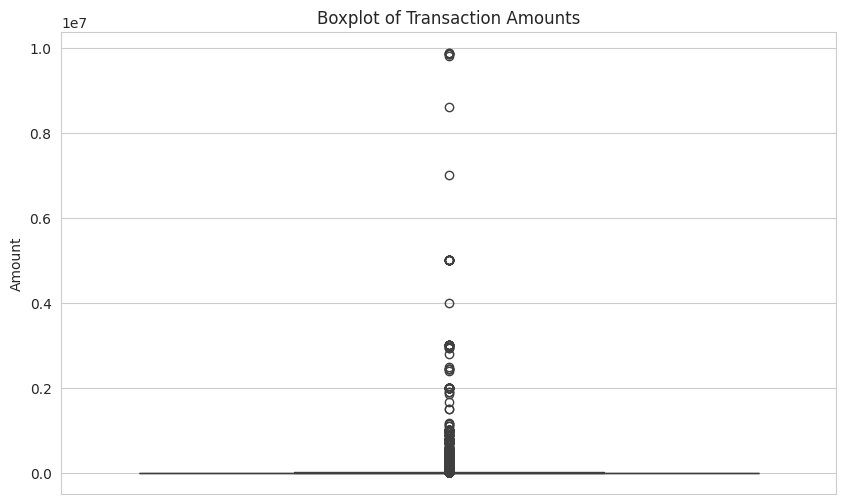

In [17]:
# We'll plot the distribution of the Amount field to visually inspect the outliers.
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of Amounts
plt.figure(figsize=(10, 6))
sns.boxplot(df_cleaned['Amount'])
plt.title('Boxplot of Transaction Amounts')
plt.show()

#### The boxplot  shows transaction amounts, where most of the data is concentrated at lower values, while there are some significant outliers (points far above the box).

In [18]:
# Apply log transformation (be cautious with negative values)
df['log_amount'] = np.log1p(df['Amount'])


In [19]:
# Cap extreme values at a certain threshold
cap_value = df['Amount'].quantile(0.99)
df['Amount_capped'] = np.where(df['Amount'] > cap_value, cap_value, df['Amount'])


In [20]:
#  Adjust IQR thresholds for stricter outlier removal
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df['Amount'] < (Q1 - 1.5 * IQR)) | (df['Amount'] > (Q3 + 1.5 * IQR)))]


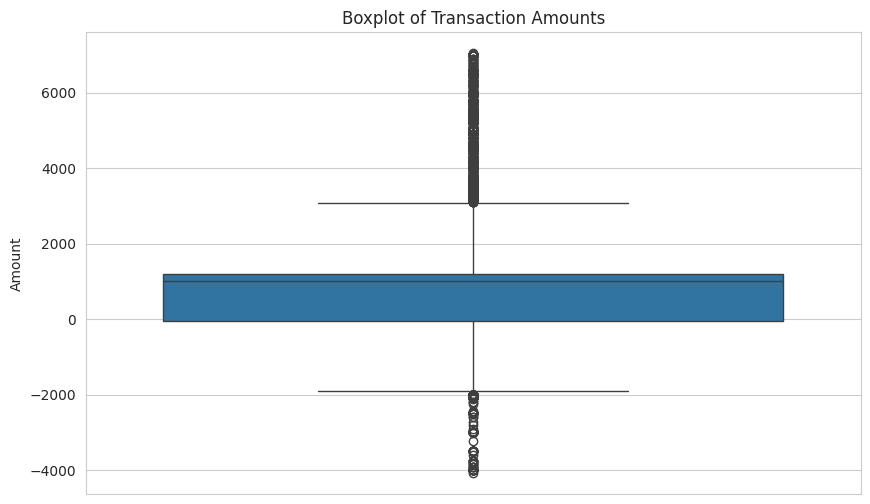

In [21]:
 # We'll plot the distribution of the Amount field to visually inspect the outliers.
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of Amounts
plt.figure(figsize=(10, 6))
sns.boxplot(df_cleaned['Amount'])
plt.title('Boxplot of Transaction Amounts')
plt.show()

#### Data is now much cleaner after the outlier removal, with the boxplot showing a more reasonable distribution. The remaining outliers may represent anomalies or natural variation in your dataset.

In [22]:
import numpy as np

# Apply log transformation (handling any non-positive values carefully)
df['Log_Amount'] = np.log1p(df['Amount'])  # log1p adds 1 to avoid issues with zero values


In [23]:
# Cap both upper and lower extremes
lower_cap = df['Amount'].quantile(0.01)
upper_cap = df['Amount'].quantile(0.99)

df['Amount_capped'] = df['Amount'].clip(lower_cap, upper_cap)


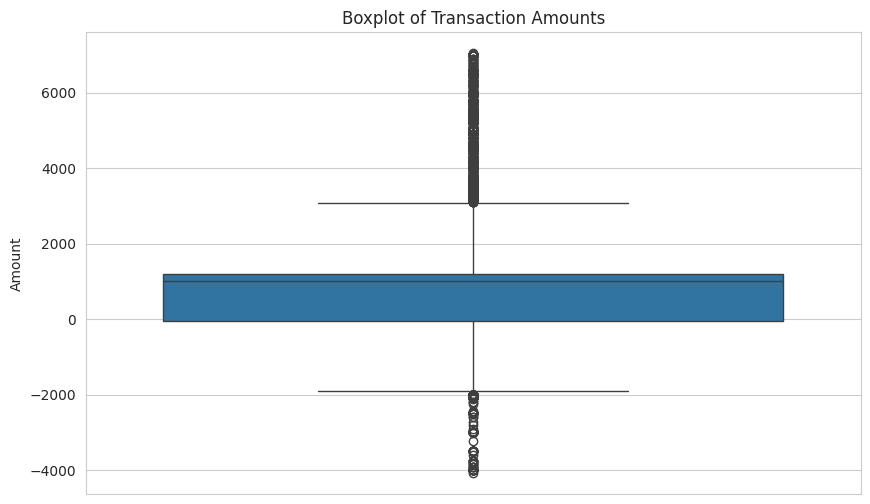

In [24]:
 # We'll plot the distribution of the Amount field to visually inspect the outliers.
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of Amounts
plt.figure(figsize=(10, 6))
sns.boxplot(df_cleaned['Amount'])
plt.title('Boxplot of Transaction Amounts')
plt.show()


## Feature Engineering:

In [25]:
# Extract new features from the TransactionStartTime column
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'])
df['Transaction_Hour'] = df['TransactionStartTime'].dt.hour
df['Transaction_Day'] = df['TransactionStartTime'].dt.day
df['Transaction_Weekday'] = df['TransactionStartTime'].dt.weekday
df['Transaction_Month'] = df['TransactionStartTime'].dt.month


In [26]:
# Encode categorical columns such as ProductCategory, ChannelId, ProviderId, etc., using methods like one-hot encoding or label encoding.
df = pd.get_dummies(df, columns=['ProductCategory', 'ChannelId', 'ProviderId'])


In [27]:
# Create ratios between the Amount and Value columns, which may indicate if a transaction is unusually high or low.
df['Amount_to_Value_Ratio'] = df['Amount'] / df['Value']


In [28]:
df['Amount_to_Value_Ratio'].head()

,Amount_to_Value_Ratio
0,1.000
1,-1.000
2,1.000
3,0.917
4,-1.000


# Correlation Analysis:
#### Check for correlations between numerical variables (e.g., Amount, Value, PricingStrategy) and the FraudResult column to explore relationships and potential predictive power.

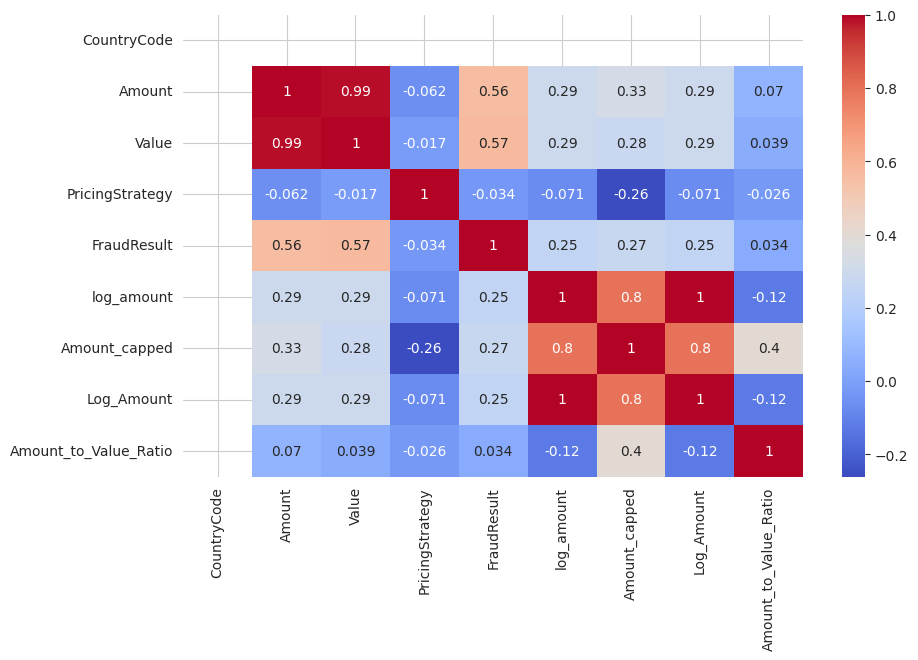

In [29]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


### Key Observations
High Correlations:

    Amount and Value: 0.99 (Very strong positive correlation)
    log_amount and Amount_capped: 0.8 (Strong positive correlation)
    Log_Amount and Amount_capped: 0.8 (Strong positive correlation)
Moderate Correlations:

    PricingStrategy and Amount: -0.062 (Moderate negative correlation)
    PricingStrategy and Value: -0.017 (Moderate negative correlation)
    FraudResult and Amount: 0.25 (Moderate positive correlation)
    FraudResult and Value: 0.27 (Moderate positive correlation)
Negative Correlations:

    PricingStrategy and Fraud Result: -0.26 (Moderate negative correlation)

1. Feature Selection:
    Based on high correlation between Amount and Value, it’s recommended to drop one of these to avoid redundancy. Since the correlation is nearly 1, there will be little loss of information by excluding one.
    For features like PricingStrategy that show moderate correlation with FraudResult, keep them in the model as they might help in fraud detection.
2. Handle Multicollinearity:
    Strong correlations between Log_Amount, Amount, and Amount_capped suggest multicollinearity. For model building, you should keep only one   version of the transformed Amount variable. If Amount_capped helps reduce outliers, it could be more effective to keep.

In [30]:
# Dropping Value due to high correlation with Amount
df_cleaned = df.drop(columns=['Value'])

# Keeping Amount_capped and dropping other variations
df_cleaned = df_cleaned.drop(columns=['Amount', 'Log_Amount'])  # Drop original Amount and Log_Amount

# Displaying the cleaned DataFrame
print("Cleaned DataFrame:")
print(df_cleaned.head())

Cleaned DataFrame:
         TransactionId         BatchId       AccountId       SubscriptionId  \
0  TransactionId_76871   BatchId_36123  AccountId_3957   SubscriptionId_887   
1  TransactionId_73770   BatchId_15642  AccountId_4841  SubscriptionId_3829   
2  TransactionId_26203   BatchId_53941  AccountId_4229   SubscriptionId_222   
3    TransactionId_380  BatchId_102363   AccountId_648  SubscriptionId_2185   
4  TransactionId_28195   BatchId_38780  AccountId_4841  SubscriptionId_3829   

        CustomerId CurrencyCode  CountryCode     ProductId  \
0  CustomerId_4406          UGX          256  ProductId_10   
1  CustomerId_4406          UGX          256   ProductId_6   
2  CustomerId_4683          UGX          256   ProductId_1   
3   CustomerId_988          UGX          256  ProductId_21   
4   CustomerId_988          UGX          256   ProductId_6   

       TransactionStartTime  PricingStrategy  FraudResult  log_amount  \
0 2018-11-15 02:18:49+00:00                2            0   

In [31]:
# Save the cleaned DataFrame to a CSV file
df_encoded.to_csv('/content/cleaned_data.csv', index=False)


NameError: name 'df_encoded' is not defined